### PMI Score calculation

The following includes my initial calculations of PMI scores, these calculation are done using code from Pew Analytics Research. I copy their function, but full their full code see python file called: 'mutual_info.py'. See details of these function here: https://pewresearch.github.io/pewanalytics/examples.html#mutual-information.


In [ ]:
import pandas as pd
import math
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def is_null(val, empty_lists_are_null=False, custom_nulls=None):

    """
    Returns the opposite of the outcome of :py:func:`pewtils.is_not_null`. The following values are always \
    considered null: ``numpy.nan, None, "None", "nan", "", " ", "NaN", "none", "n/a", "NONE", "N/A"``

    :param val: The value to check
    :param empty_lists_are_null: Whether or not an empty list or :py:class:`pandas.DataFrame` should be considered \
    null (default=False)
    :type empty_lists_are_null: bool
    :param custom_nulls: an optional list of additional values to consider as null
    :type custom_nulls: list
    :return: True if the value is null
    :rtype: bool

    Usage::

        from pewtils import is_null

        >>> empty_list = []
        >>> is_null(empty_list, empty_lists_are_null=True)
        True
    """

    return not is_not_null(
        val, empty_lists_are_null=empty_lists_are_null, custom_nulls=custom_nulls
    )



def is_not_null(val, empty_lists_are_null=False, custom_nulls=None):

    """
    Checks whether the value is null, using a variety of potential string values, etc. The following values are always
    considered null: ``numpy.nan, None, "None", "nan", "", " ", "NaN", "none", "n/a", "NONE", "N/A"``

    :param val: The value to check
    :param empty_lists_are_null: Whether or not an empty list or :py:class:`pandas.DataFrame` should be considered \
    null (default=False)
    :type empty_lists_are_null: bool
    :param custom_nulls: an optional list of additional values to consider as null
    :type custom_nulls: list
    :return: True if the value is not null
    :rtype: bool

    Usage::

        from pewtils import is_not_null

        >>> text = "Hello"
        >>> is_not_null(text)
        True
    """

    null_values = [None, "None", "nan", "", " ", "NaN", "none", "n/a", "NONE", "N/A"]
    if custom_nulls:
        null_values.extend(custom_nulls)
    if type(val) == list:
        if empty_lists_are_null and val == []:
            return False
        else:
            return True
    elif isinstance(val, pd.Series) or isinstance(val, pd.DataFrame):
        if empty_lists_are_null and len(val) == 0:
            return False
        else:
            return True
    else:
        try:
            try:
                good = val not in null_values
                if good:
                    try:
                        try:
                            good = not pd.isnull(val)
                        except IndexError:
                            good = True
                    except AttributeError:
                        good = True
                return good
            except ValueError:
                return val.any()
        except TypeError:
            return not isinstance(val, None)




def scale_range(old_val, old_min, old_max, new_min, new_max):

    """
    Scales a value from one range to another.  Useful for comparing values from different scales, for example.

    :param old_val: The value to convert
    :type old_val: int or float
    :param old_min: The minimum of the old range
    :type old_min: int or float
    :param old_max: The maximum of the old range
    :type old_max: int or float
    :param new_min: The minimum of the new range
    :type new_min: int or float
    :param new_max: The maximum of the new range
    :type new_max: int or float
    :return: Value equivalent from the new scale
    :rtype: float

    Usage::

        from pewtils import scale_range

        >>> old_value = 5
        >>> scale_range(old_value, 0, 10, 0, 20)
        10.0
    """

    return (
        ((float(old_val) - float(old_min)) * (float(new_max) - float(new_min)))
        / (float(old_max) - float(old_min))
    ) + float(new_min)

In [ ]:

def compute_mutual_info(y, x, weights=None, col_names=None, l=0, normalize=True):

    """
    Computes pointwise mutual information for a set of observations partitioned into two groups.

    :param y: An array or, preferably, a :py:class:`pandas.Series`
    :param x: A matrix, :py:class:`pandas.DataFrame`, or preferably a :py:class:`scipy.sparse.csr_matrix`
    :param weights: (Optional) An array of weights corresponding to each observation
    :param col_names: The feature names associated with the columns in matrix 'x'
    :type col_names: list
    :param l: An optional Laplace smoothing parameter
    :type l: int or float
    :param normalize: Toggle normalization on or off (to control for feature prevalance), on by default
    :type normalize: bool
    :return: A :py:class:`pandas.DataFrame` of features with a variety of computed metrics including mutual information.

    The function expects ``y`` to correspond to a list or series of values indicating which partition an observation \
    belongs to. ``y`` must be a binary flag. ``x`` is a set of features (either a :py:class:`pandas.DataFrame` or \
    sparse matrix) where the rows correspond to observations and the columns represent the presence of features (you \
    can technically run this using non-binary features but the results will not be as readily interpretable.) The \
    function returns a :py:class:`pandas.DataFrame` of metrics computed for each feature, including the following \
    columns:

    - ``MI1``: The feature's mutual information for the positive class
    - ``MI0``: The feature's mutual information for the negative class
    - ``total``: The total number of times a feature appeared
    - ``total_pos_with_term``: The total number of times a feature appeared in positive cases
    - ``total_neg_with_term``: The total number of times a feature appeared in negative cases
    - ``total_pos_neg_with_term_diff``: The raw difference in the number of times a feature appeared in positive cases \
    relative to negative cases
    - ``pct_pos_with_term``: The proportion of positive cases that had the feature
    - ``pct_neg_with_term``: The proportion of negative cases that had the feature
    - ``pct_pos_neg_with_term_ratio``: A likelihood ratio indicating the degree to which a positive case was more likely \
    to have the feature than a negative case
    - ``pct_term_pos``: Of the cases that had a feature, the proportion that were in the positive class
    - ``pct_term_neg``: Of the cases that had a feature, the proportion that were in the negative class
    - ``pct_term_pos_neg_diff``: The percentage point difference between the proportion of cases with the feature that \
    were positive vs. negative
    - ``pct_term_pos_neg_ratio``: A likelihood ratio indicating the degree to which a feature was more likely to appear \
    in a positive case relative to a negative one (may not be meaningful when classes are imbalanced)

    .. note:: Note that ``pct_term_pos`` and ``pct_term_neg`` may not be directly comparable if classes are imbalanced, \
        and in such cases a ``pct_term_pos_neg_diff`` above zero or ``pct_term_pos_neg_ratio`` above 1 may not indicate a \
        true association with the positive class if positive cases outnumber negative ones.

    .. note:: Mutual information can be a difficult metric to explain to others. We've found that the \
        ``pct_pos_neg_with_term_ratio`` can serve as a more interpretable alternative method for identifying \
        meaningful differences between groups.

    Usage::

        from pewanalytics.stats.mutual_info import compute_mutual_info
        import nltk
        import pandas as pd
        from sklearn.metrics.pairwise import linear_kernel
        from sklearn.feature_extraction.text import TfidfVectorizer

        nltk.download("inaugural")
        df = pd.DataFrame([
            {"speech": fileid, "text": nltk.corpus.inaugural.raw(fileid)} for fileid in nltk.corpus.inaugural.fileids()
        ])
        df['year'] = df['speech'].map(lambda x: int(x.split("-")[0]))
        df['21st_century'] = df['year'].map(lambda x: 1 if x >= 2000 else 0)

        vec = TfidfVectorizer(min_df=10, max_df=.9).fit(df['text'])
        tfidf = vec.transform(df['text'])

        # Here are the terms most distinctive of inaugural addresses in the 21st century vs. years prior

        >>> results = compute_mutual_info(df['21st_century'], tfidf, col_names=vec.get_feature_names())

        >>> results.sort_values("MI1", ascending=False).index[:25]
        Index(['america', 'thank', 'bless', 'schools', 'ideals', 'americans',
               'meaning', 'you', 'move', 'across', 'courage', 'child', 'birth',
               'generation', 'families', 'build', 'hard', 'promise', 'choice', 'women',
               'guided', 'words', 'blood', 'dignity', 'because'],
              dtype='object')

    """

    if is_not_null(weights):
        weights = weights.fillna(0)
        y0 = sum(weights[y == 0])
        y1 = sum(weights[y == 1])
        total = sum(weights)
    else:
        y0 = len(y[y == 0])
        y1 = len(y[y == 1])
        total = y1 + y0

    if type(x).__name__ == "csr_matrix":

        if is_not_null(weights):
            x = x.transpose().multiply(csr_matrix(weights)).transpose()
        x1 = pd.Series(x.sum(axis=0).tolist()[0])
        x0 = total - x1
        x1y0 = pd.Series(
            x[np.ravel(np.array(y[y == 0].index)), :].sum(axis=0).tolist()[0]
        )
        x1y1 = pd.Series(
            x[np.ravel(np.array(y[y == 1].index)), :].sum(axis=0).tolist()[0]
        )

    else:

        if type(x).__name__ != "DataFrame":
            x = pd.DataFrame(x, columns=col_names)

        if is_not_null(weights):
            x = x.multiply(weights, axis="index")
            x1 = x.multiply(weights, axis="index").sum()
            x0 = ((x * -1) + 1).multiply(weights, axis="index").sum()
        else:
            x1 = x.sum()
            x0 = ((x * -1) + 1).sum()
        x1y0 = x[y == 0].sum()
        x1y1 = x[y == 1].sum()

    px1y0 = x1y0 / total
    px1y1 = x1y1 / total
    px0y0 = (y0 - x1y0) / total
    px0y1 = (y1 - x1y1) / total

    px1 = x1 / total
    px0 = x0 / total
    py1 = float(y1) / float(total)
    py0 = float(y0) / float(total)

    MI1 = (px1y1 / (px1 * py1) + l).map(lambda v: math.log(v, 2) if v > 0 else 0)
    if normalize:
        MI1 = MI1 / (-1 * px1y1.map(lambda v: math.log(v, 2) if v > 0 else 0))

    MI0 = (px1y0 / (px1 * py0) + l).map(lambda v: math.log(v, 2) if v > 0 else 0)
    if normalize:
        MI0 = MI0 / (-1 * px1y0.map(lambda v: math.log(v, 2) if v > 0 else 0))

    df = pd.DataFrame()

    df["MI1"] = MI1
    df["MI0"] = MI0

    df["total"] = x1
    df["total_pos_with_term"] = x1y1  # total_pos_mention
    df["total_neg_with_term"] = x1y0  # total_neg_mention
    df["total_pos_neg_with_term_diff"] = (
        df["total_pos_with_term"] - df["total_neg_with_term"]
    )
    df["pct_with_term"] = x1 / (x1 + x0)
    df["pct_pos_with_term"] = x1y1 / y1  # pct_pos_mention
    df["pct_neg_with_term"] = x1y0 / y0  # pct_neg_mention
    df["pct_pos_neg_with_term_diff"] = (
        df["pct_pos_with_term"] - df["pct_neg_with_term"]
    )  # pct_pos_neg_mention_diff
    df["pct_pos_neg_with_term_ratio"] = df["pct_pos_with_term"] / (
        df["pct_neg_with_term"]
    )  # pct_pos_neg_mention_ratio

    df["pct_term_pos"] = x1y1 / x1  # pct_mention_pos
    df["pct_term_neg"] = x1y0 / x1  # pct_mention_neg
    df["pct_term_pos_neg_diff"] = (
        df["pct_term_pos"] - df["pct_term_neg"]
    )  # pct_mention_pos_neg_diff
    df["pct_term_pos_neg_ratio"] = df["pct_term_pos"] / df["pct_term_neg"]

    if col_names is not None and len(col_names) > 0:
        df.index = col_names

    return df


def mutual_info_bar_plot(
    mutual_info,
    filter_col="MI1",
    top_n=50,
    x_col="pct_term_pos_neg_ratio",
    color="grey",
    title=None,
    width=10,
):
    """
    Takes a mutual information table generated by :py:func:`pewanalytics.stats.mutual_info.compute_mutual_info`, \
    and generates a bar plot of top features. Allows for an easy visualization of feature differences. Can \
    subsequently call :py:func:`plt.show` or :py:func:`plt.savefig` to display or save the plot.

    :param mutual_info: A mutual information table generated by \
    :py:func:`pewanalytics.stats.mutual_info.compute_mutual_info`
    :param filter_col: The column to use when selecting top features; sorts in descending order and picks the \
    top ``top_n``
    :type filter_col: str
    :param top_n: The number of features to display
    :type top_n: int
    :param x_col: The column by which to sort the final set of top features (after they have been selected by \
    ``filter_col``
    :type x_col: str
    :param color: The color of the bars
    :type color: str
    :param title: The title of the plot
    :type title: str
    :param width: The width of the plot
    :type width: int
    :return: A Matplotlib figure, which you can display via ``plt.show()`` or alternatively save to a file via \
    ``plt.savefig(FILEPATH)``
    """

    import seaborn
    import matplotlib.pyplot as plt

    mutual_info = mutual_info.sort_values(filter_col, ascending=False)[:top_n]
    mutual_info = mutual_info.sort_values(x_col, ascending=False)
    mutual_info["ngram"] = mutual_info.index
    buffer = 0.02 * abs(mutual_info[x_col].max() - mutual_info[x_col].min())
    plt.figure(figsize=(width, float(len(mutual_info) * 0.35)))
    seaborn.set_color_codes("pastel")  # noqa: F821
    g = seaborn.barplot(x=x_col, y="ngram", data=mutual_info, color=color)  # noqa: F821
    seaborn.despine(offset=10, trim=True)  # noqa: F821
    for i, row in enumerate(mutual_info.iterrows()):
        index, row = row
        g.text(
            x=row[x_col] + buffer,
            y=i,
            s=row["ngram"],
            horizontalalignment="left",
            verticalalignment="center",
            size="large",
            color=color,
        )
    g.set_title(title)

    return g


def mutual_info_scatter_plot(
    mutual_info,
    filter_col="MI1",
    top_n=25,
    x_col="pct_term_pos_neg_ratio",
    xlabel=None,
    scale_x_even=True,
    y_col="MI1",
    ylabel=None,
    scale_y_even=True,
    color="grey",
    color_col="MI1",
    size_col="pct_pos_with_term",
    title=None,
    figsize=(10, 10),
    adjust_text=False,
):
    """

    Takes a mutual information table generated by :py:func:`pewanalytics.stats.mutual_info.compute_mutual_info`, \
    and generates a scatter plot of top features.
    The names of the features will be displayed with varying colors and sizes depending on the variables specified
    in ``color_col`` and ``size_col``. Allows for an easy visualization of feature differences. Can subsequently
    call :py:func:`plt.show` or :py:func:`plt.savefig` to display or save the plot.

    :param mutual_info: A mutual information table generated by \
    :py:func:`pewanalytics.stats.mutual_info.compute_mutual_info`
    :param filter_col: The column to use when selecting top features; sorts in descending order and picks the top \
    ``top_n``
    :type filter_col: str
    :param top_n: The number of features to display
    :type top_n: int
    :param x_col: The column to use as the x-axis
    :type x_col: str
    :param xlabel: Label for the x-axis
    :type xlabel: str
    :param scale_x_even: If True, set values to their ordered rank (allows for even spacing)
    :type scale_x_even: bool
    :param y_col: The column to use as the y-axis
    :type y_col: str
    :param ylabel: Label for the y-axis
    :type ylabel: str
    :param scale_y_even: If True, set values to their ordered rank (allows for even spacing)
    :type scale_y_even: bool
    :param color: The color for the features
    :type color: str
    :param color_col: The column to use when shading the features
    :type color_col: str
    :param size_col: The column to use to size the features
    :type size_col: str
    :param title: The title of the plot
    :type title: str
    :param figsize: The size of the plot (tuple)
    :type figsize: tuple
    :param adjust_text: If True, attempts to adjusts the text so it doesn't overlap
    :type adjust_text: bool
    :return: A Matplotlib figure, which you can display via ``plt.show()`` or alternatively save to a file via \
    ``plt.savefig(FILEPATH)``
    """

    import seaborn
    import matplotlib.pyplot as plt

    mutual_info = mutual_info.sort_values(filter_col, ascending=False)[:top_n]

    if scale_x_even:
        mutual_info = mutual_info.sort_values(x_col)
        mutual_info["{}_rank".format(x_col)] = mutual_info.reset_index().index + 1
        x_col = "{}_rank".format(x_col)
    if scale_y_even:
        mutual_info = mutual_info.sort_values(y_col)
        mutual_info["{}_rank".format(y_col)] = mutual_info.reset_index().index + 1
        y_col = "{}_rank".format(y_col)

    color_maps = {
        "grey": plt.cm.Greys,
        "purple": plt.cm.Purples,
        "blue": plt.cm.Blues,
        "green": plt.cm.Greens,
        "orange": plt.cm.Oranges,
        "red": plt.cm.Reds,
    }

    _, ax = plt.subplots(figsize=figsize)
    seaborn.scatterplot(
        data=mutual_info, x=x_col, y=y_col, legend=False, alpha=0.0, ax=ax
    )  # noqa: F821
    seaborn.set_color_codes("pastel")  # noqa: F821

    mutual_info["size"] = mutual_info[size_col].map(
        lambda x: scale_range(
            x,
            mutual_info[size_col].min(),
            mutual_info[size_col].max(),
            (figsize[0] * 3),
            (figsize[0] * 5),
        )
    )
    mutual_info["color"] = mutual_info[color_col].map(
        lambda x: scale_range(
            x, mutual_info[color_col].min(), mutual_info[color_col].max(), 0.4, 1
        )
    )
    mutual_info["color"] = mutual_info["color"].map(color_maps[color])

    mutual_info["x"] = mutual_info[x_col]
    mutual_info["y"] = mutual_info[y_col]
    ax.set_title(title)
    ax.set_xlim((mutual_info["x"].min(), mutual_info["x"].max()))
    ax.set_ylim((mutual_info["y"].min(), mutual_info["y"].max()))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    texts = []
    for index, row in mutual_info.iterrows():
        texts.append(
            ax.text(
                row["x"],
                row["y"],
                index,
                size=row["size"],
                color=row["color"],
                horizontalalignment="right"
                if row["x"] > (mutual_info["x"].max() / 2.0)
                else "left",
                verticalalignment="top"
                if row["y"] > (mutual_info["y"].max() / 2.0)
                else "bottom",
            )
        )
    if adjust_text:
        adjust_text_function(
            texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5, alpha=0.5)
        )

    seaborn.despine(offset=10, trim=True)  # noqa: F821

    return ax


In [ ]:
# liwc_analysis = pd.read_csv('../Documents/Social Data Science - Masters/Thesis/Data/LIWC-22 Results - guardian_classified_clean - LIWC Analysis.csv')

In [ ]:
liwc_analysis_women = pd.read_csv('/content/drive/MyDrive/SDS/Thesis/Data/liwc_analysis_women.csv')


In [ ]:
# read in liwc_analysis_men
liwc_analysis_men = pd.read_csv('/content/drive/MyDrive/SDS/Thesis/Data/liwc_analysis_men.csv')

In [ ]:
liwc_analysis_men.head()

,Unnamed: 0,type,sectionName,webTitle,webUrl,date,headline,article_text,word_count,author,...,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji,Gender
0,0,article,Football,Why always him? What made Rodgers turn to Mari...,https://www.theguardian.com/football/blog/2015...,2015-01-28,Why always him? What made Rodgers turn to Mari...,With all eyes on Diego Costa and where he stam...,720,Andy Hunter,...,0.0,15.98,4.64,3.83,0.27,0.0,3.55,3.69,0.0,Men
1,1,article,Football,Football transfer rumours: Mario Suárez to Ars...,https://www.theguardian.com/football/2015/jan/...,2015-01-01,Football transfer rumours: Mario Suárez to Ars...,"Fizzle, crackle, crackle, fizzle, crackle, cra...",434,Gregg Bakowski,...,0.0,22.62,10.86,3.85,1.13,0.9,4.52,1.36,0.0,Men
2,2,article,Football,Kenny Lowe: the man leading Perth Glory to the...,https://www.theguardian.com/football/2015/jan/...,2015-01-01,Kenny Lowe: the man leading Perth Glory to the...,Kenny Lowe jokes that when he leaves Perth Glo...,937,Jack Kerr,...,0.0,20.82,6.13,5.50,0.32,0.0,4.33,4.55,0.0,Men
3,3,article,Football,Manchester United consider Aston Villa’s Ron V...,https://www.theguardian.com/football/2015/jan/...,2015-01-01,Manchester United consider Aston Villa’s Ron V...,Ron Vlaar is under consideration by Louis van ...,299,Jamie Jackson,...,0.0,11.00,2.59,5.18,0.00,0.0,1.29,1.94,0.0,Men
4,4,article,Football,Tony Pulis appointed West Brom head coach on t...,https://www.theguardian.com/football/2015/jan/...,2015-01-01,Tony Pulis appointed West Brom head coach on t...,Tony Pulis has been appointed as the new head ...,306,Guardian sport,...,0.0,17.46,3.49,4.76,0.00,0.0,2.54,6.67,0.0,Men


In [ ]:
# Sample data
men_text = [liwc_analysis_men['article_text'][0].split(), liwc_analysis_men['article_text'][1].split()]
women_text = [liwc_analysis_women['article_text'][0].split(), liwc_analysis_women['article_text'][1].split()]
# Ensure all elements are strings and remove any None values
men_text = [str(item) for item in men_text if item is not None]
women_text = [str(item) for item in women_text if item is not None]


vectorizer = CountVectorizer()
X = vectorizer.fit_transform(men_text + women_text)  # Vectorizes combined texts

# Convert to dense format (optional)
X_dense = X.toarray()

# Define labels: 0 for men, 1 for women
y = np.array([0] * len(men_text) + [1] * len(women_text))

# Define column names for the features
col_names = vectorizer.get_feature_names_out()


# Now you can pass these to compute_mutual_info
result = compute_mutual_info(y, X_dense, col_names=col_names)
print(result)


                MI1       MI0  total  total_pos_with_term  \
000        2.409421       NaN      3                    3   
15         0.500000       NaN      1                    1   
160        0.500000       NaN      1                    1   
16m             NaN  0.500000      1                    0   
17         0.500000       NaN      1                    1   
...             ...       ...    ...                  ...   
yellow          NaN  0.500000      1                    0   
yes             NaN  1.000000      2                    0   
yesterday  0.000000  0.000000      2                    1   
york       0.000000  0.000000      2                    1   
you             NaN -0.854756      9                    0   

           total_neg_with_term  total_pos_neg_with_term_diff  pct_with_term  \
000                          0                             3           0.75   
15                           0                             1           0.25   
160                          0

In [ ]:
result

,MI1,MI0,total,total_pos_with_term,total_neg_with_term,total_pos_neg_with_term_diff,pct_with_term,pct_pos_with_term,pct_neg_with_term,pct_pos_neg_with_term_diff,pct_pos_neg_with_term_ratio,pct_term_pos,pct_term_neg,pct_term_pos_neg_diff,pct_term_pos_neg_ratio
000,2.409421,NaN,3,3,0,3,0.75,1.5,0.0,1.5,inf,1.0,0.0,1.0,inf
15,0.500000,NaN,1,1,0,1,0.25,0.5,0.0,0.5,inf,1.0,0.0,1.0,inf
160,0.500000,NaN,1,1,0,1,0.25,0.5,0.0,0.5,inf,1.0,0.0,1.0,inf
16m,NaN,0.500000,1,0,1,-1,0.25,0.0,0.5,-0.5,0.0,0.0,1.0,-1.0,0.0
17,0.500000,NaN,1,1,0,1,0.25,0.5,0.0,0.5,inf,1.0,0.0,1.0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yellow,NaN,0.500000,1,0,1,-1,0.25,0.0,0.5,-0.5,0.0,0.0,1.0,-1.0,0.0
yes,NaN,1.000000,2,0,2,-2,0.50,0.0,1.0,-1.0,0.0,0.0,1.0,-1.0,0.0
yesterday,0.000000,0.000000,2,1,1,0,0.50,0.5,0.5,0.0,1.0,0.5,0.5,0.0,1.0
york,0.000000,0.000000,2,1,1,0,0.50,0.5,0.5,0.0,1.0,0.5,0.5,0.0,1.0


In [ ]:
# womens text
result.sort_values("MI1", ascending=False).index[:25]

Index(['who', 'his', 'for', 'was', 'united', 'sheffield', 'culture',
       'football', 'offered', '000', 'minister', 'issue', 'up', 'offer',
       'convicted', 'bieber', 'supporters', 'justice', 'statement', 'side',
       'confederation', 'sexual', 'matches', 'organisations', 'sensitive'],
      dtype='object')

In [ ]:
# mens text
result.sort_values("MI0", ascending=False).index[:25]

Index(['way', 'can', 'll', 'out', 'bolton', 'sniffing', 'how', 'do', 'first',
       'has', 'around', 'so', 'before', 'only', 'going', 'man', 'again',
       'well', 'off', 'got', 'suit', 'happy', 'than', 'suárez', 'then'],
      dtype='object')

In [ ]:


# Sample data (assuming liwc_analysis_men and liwc_analysis_women are DataFrames)
# Test for the first 10 rows of the 'article_text' column
men_text = [str(text).split() for text in liwc_analysis_men['article_text'] if text is not None]
women_text = [str(text).split() for text in liwc_analysis_women['article_text'] if text is not None]

# Join the lists back into strings so they are ready for vectorization
men_text = [" ".join(text) for text in men_text]
women_text = [" ".join(text) for text in women_text]

# Combine both men_text and women_text for vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(men_text + women_text)

# Convert to dense format if necessary
X_dense = X.toarray()

# Define labels: 0 for men, 1 for women
y = np.array([0] * len(men_text) + [1] * len(women_text))

# Define column names for the features
col_names = vectorizer.get_feature_names_out()

# Compute mutual information
result_full = compute_mutual_info(y, X_dense, col_names=col_names)



In [ ]:
# save result full
result_full.to_csv('/content/drive/MyDrive/SDS/Thesis/Data/pmi_result_full.csv')

In [ ]:
# womens text
result_full.sort_values("MI1", ascending=False).index[:50]

Index(['her', 'she', 'women', 'kerr', 'matildas', 'hayes', 'wsl', 'mead',
       'bronze', 'wiegman', 'kirby', 'hemp', 'miedema', 'lionesses', 'russo',
       'foord', 'earps', 'rapinoe', 'girls', 'stanway', 'parris', 'emma',
       'lauren', 'toone', 'beth', 'canada', 'williamson', 'sampson',
       'cuthbert', 'reiten', 'nwsl', 'herself', 'daly', 'lucy', 'sarina',
       'catley', 'houghton', 'nobbs', 'eidevall', 'blackstenius', 'england',
       'jill', 'gustavsson', 'raso', 'mccabe', 'lyon', 'berger', 'leah',
       'skinner', 'zinsberger'],
      dtype='object')

In [ ]:
# mens text
result_full.sort_values("MI0", ascending=False).index[:50]

Index(['final', 'arsenal', 'still', 'home', 'cup', 'chelsea', 'old', 'even',
       'west', 'because', 'man', 'too', 'did', 'end', 'newcastle', 'fans',
       'palace', 'leicester', 'since', 'mourinho', 'get', 'might', 'guardiola',
       'himself', 'klopp', 'real', 'david', 'kane', 'years', 'madrid', 'ham',
       'southampton', 'everton', 'while', 'well', 'burnley', 'should',
       'bournemouth', 'side', 'made', 'may', 'leeds', 'watford', 'southgate',
       'day', 'messi', 'sterling', 'wolves', 'wenger', 'fulham'],
      dtype='object')

<Axes: xlabel='pct_term_pos_neg_ratio', ylabel='ngram'>

/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:365: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


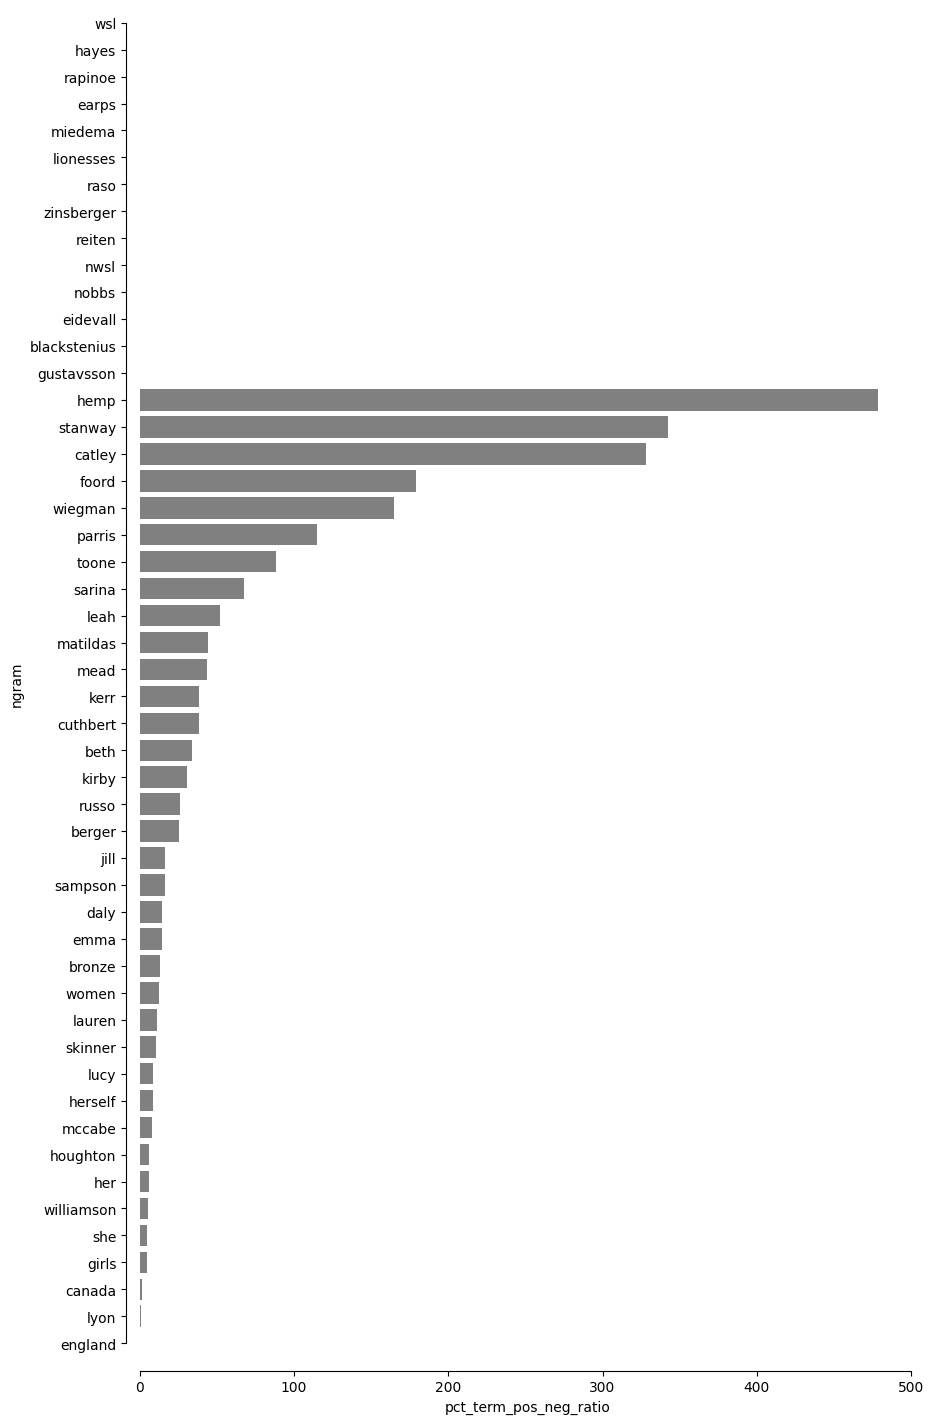

In [ ]:
mutual_info_bar_plot(result_full)

<Axes: >

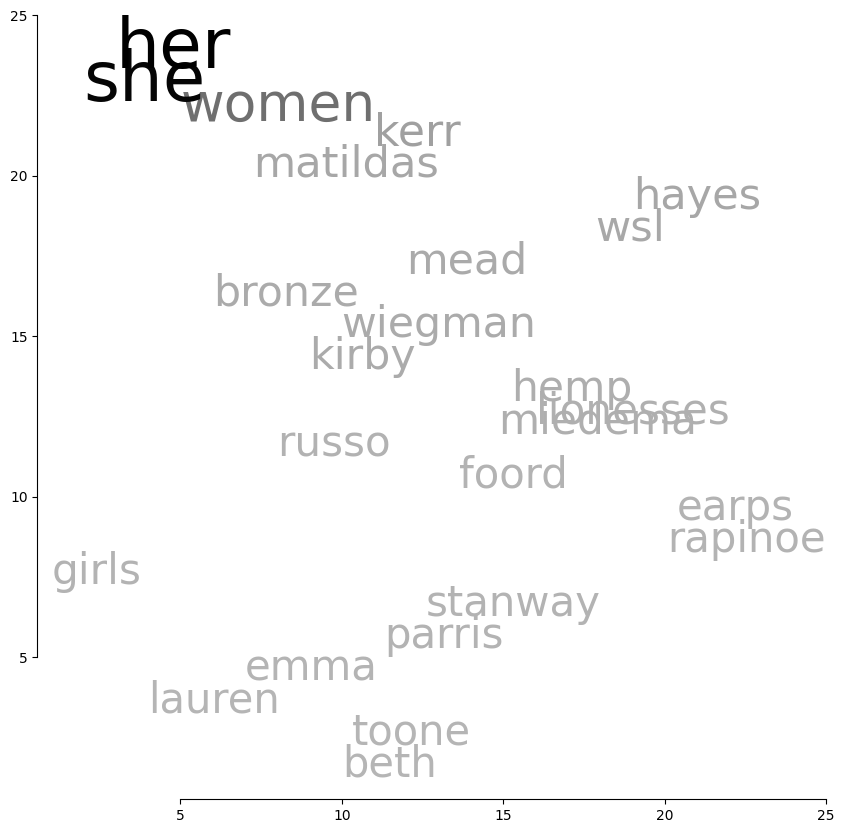

In [ ]:
mutual_info_scatter_plot(result_full)

<Axes: >

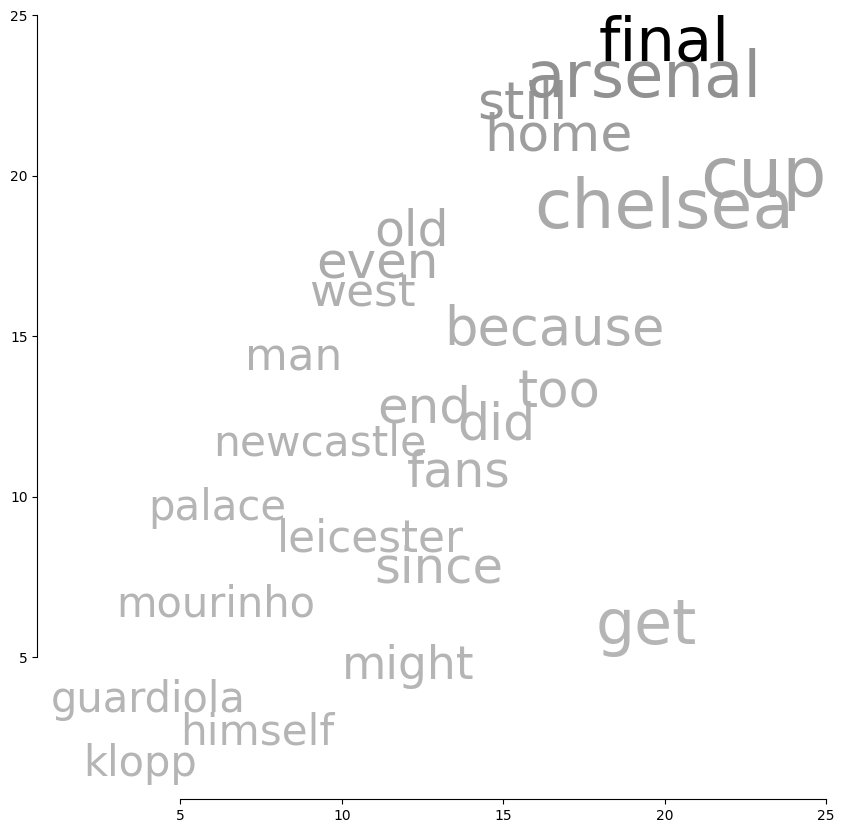

In [ ]:
mutual_info_scatter_plot(result_full)